In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import joblib
import os

In [5]:
print("Loading dataset...")

DATA_PATH = "../data/bodmas.npz"
META_PATH = "../data/bodmas_metadata.csv"

data = np.load(DATA_PATH)
X = data["X"]
y = data["y"]
meta = pd.read_csv(META_PATH)

print(f"Features shape: {X.shape}, Labels shape: {y.shape}")
print(meta.head())

Loading dataset...
Features shape: (134435, 2381), Labels shape: (134435,)
                                                 sha  \
0  e6d7b4bab32def853ab564410df53fa33172dda1bfd48c...   
1  5af37a058a5bcf2284c183ee98d92b7c66d8f5ce623e92...   
2  5bfbbea150af5cef2d3a93b80ef7c7faea9f564b56045d...   
3  216f592f1e1717d5681b7f5f2b14a28a2f0c603b5b7318...   
4  a1ca76813d2e9e7e23b830c87fbe29bcb51fcbe096e445...   

                   timestamp family  
0  2007-01-01 08:46:39+00:00    NaN  
1  2007-01-26 17:16:30+00:00    NaN  
2  2007-03-21 02:08:53+00:00    NaN  
3  2007-04-25 12:55:06+00:00    NaN  
4  2007-11-14 15:03:55+00:00    NaN  


C:\Users\Thinkbook 14\AppData\Local\Temp\ipykernel_4924\374904167.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=malware_count.index, y=malware_count.values, palette="coolwarm")


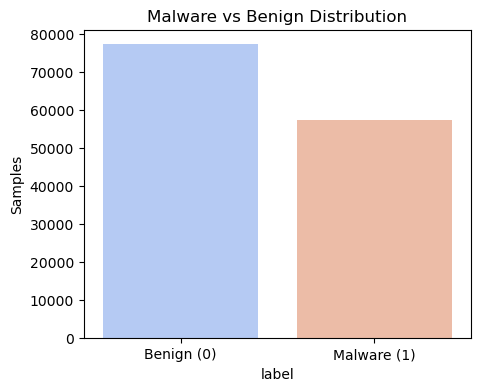

In [6]:
df = pd.DataFrame(meta)
df["label"] = y
malware_count = df["label"].value_counts()

plt.figure(figsize=(5, 4))
sns.barplot(x=malware_count.index, y=malware_count.values, palette="coolwarm")
plt.title("Malware vs Benign Distribution")
plt.xticks([0, 1], ["Benign (0)", "Malware (1)"])
plt.ylabel("Samples")
plt.show()

In [7]:
# ------------------------------------------------
# 3️⃣ Train/Test Split
# ------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (107548, 2381), Test: (26887, 2381)


In [8]:
# ------------------------------------------------
# 4️⃣ Scaling
# ------------------------------------------------
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# ------------------------------------------------
# 5️⃣ Train LightGBM Classifier
# ------------------------------------------------
print("Training LightGBM baseline model...")
model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train_scaled, y_train)

Training LightGBM baseline model...
[LightGBM] [Info] Number of positive: 45834, number of negative: 61714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.100678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195185
[LightGBM] [Info] Number of data points in the train set: 107548, number of used features: 2309
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [10]:
# ------------------------------------------------
# 6️⃣ Evaluate
# ------------------------------------------------
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

c:\Users\Public\conda\envs\aimap\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Public\conda\envs\aimap\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [11]:
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")
print(f"✅ AUC: {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.9977
✅ F1-score: 0.9972
✅ AUC: 0.9999

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     15428
           1       1.00      1.00      1.00     11459

    accuracy                           1.00     26887
   macro avg       1.00      1.00      1.00     26887
weighted avg       1.00      1.00      1.00     26887



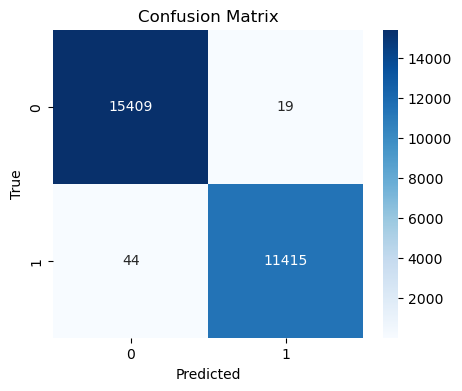

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

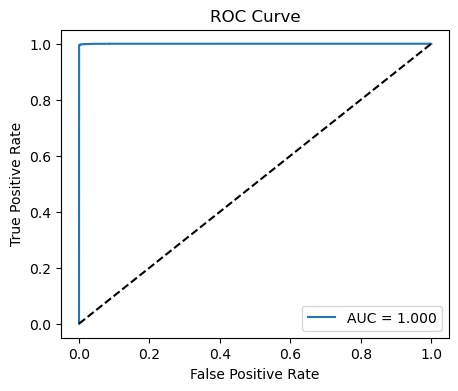

In [13]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [14]:
# ------------------------------------------------
# 6️⃣ Save Model
# ------------------------------------------------
os.makedirs("../models", exist_ok=True)
joblib.dump(model, "../models/lightgbm_baseline.pkl")
joblib.dump(scaler, "../models/scaler_baseline.pkl")
print("✅ Model and scaler saved to ../models/")

✅ Model and scaler saved to ../models/


c:\Users\Public\conda\envs\aimap\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Public\conda\envs\aimap\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


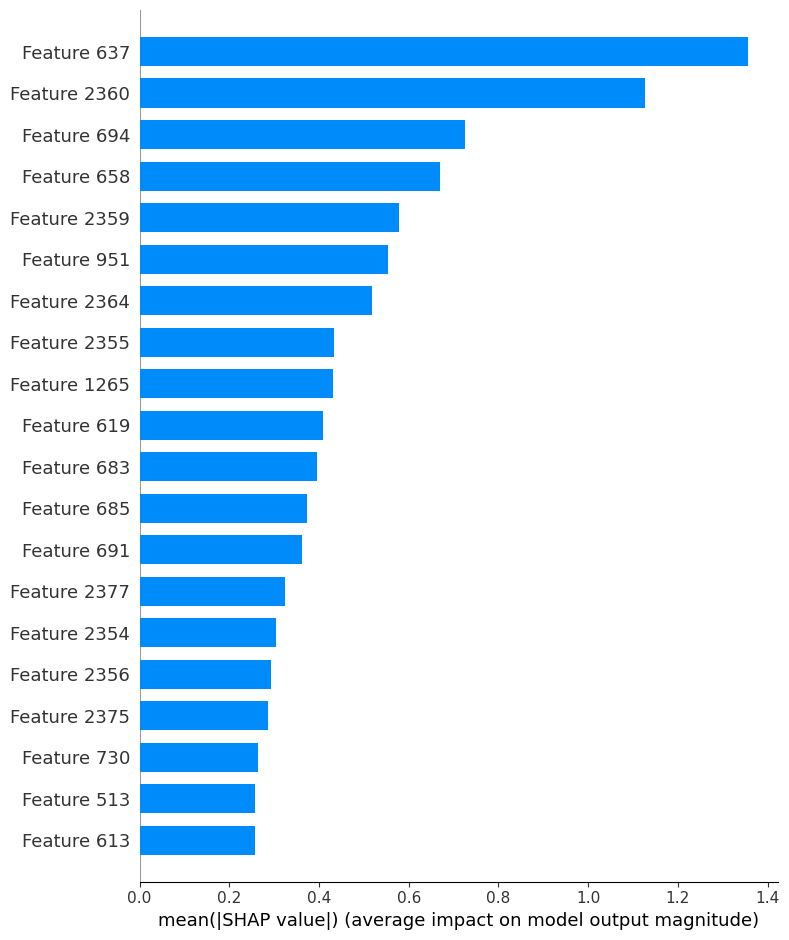

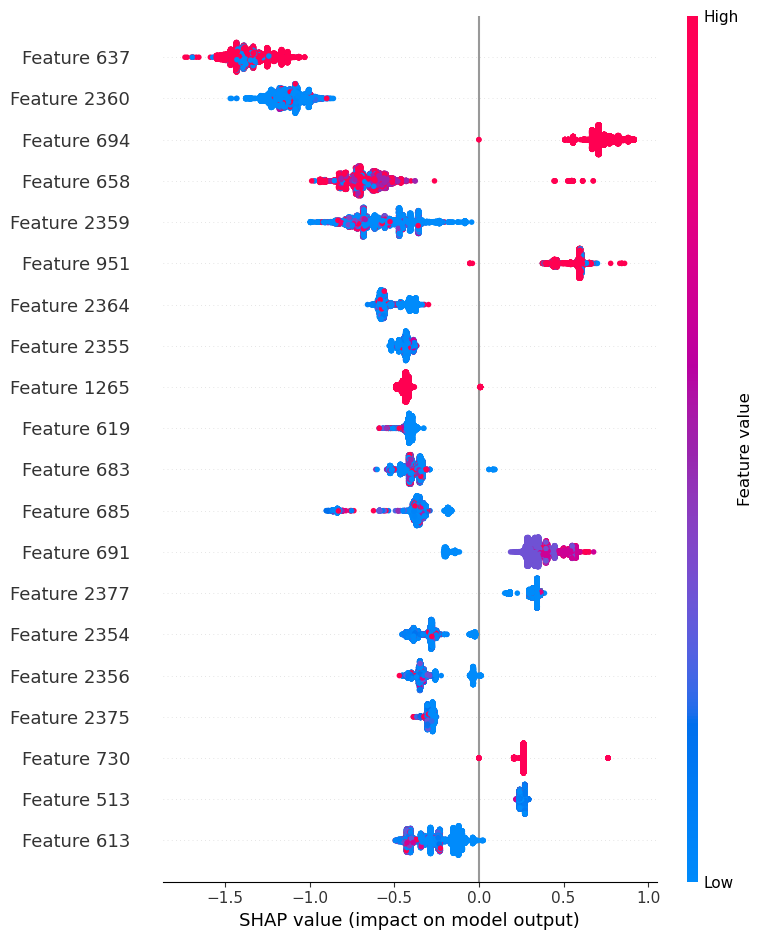

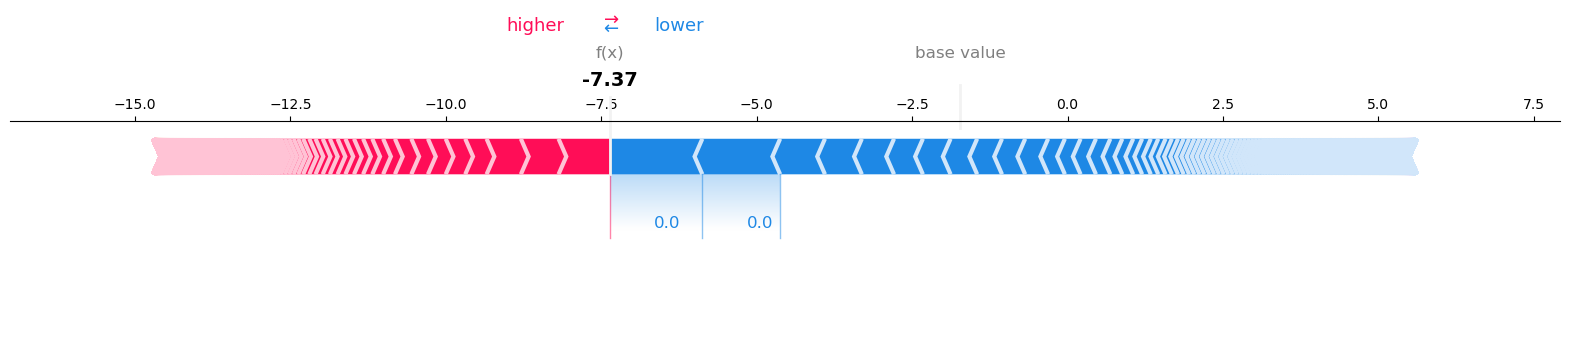

In [15]:
# ------------------------------------------------
# 🧠 SHAP Explainability
# ------------------------------------------------
import shap

# Initialize SHAP TreeExplainer for LightGBM
explainer = shap.TreeExplainer(model)

# Compute SHAP values for a subset (to save time)
X_sample = X_test[:6200]   # you can adjust sample size
shap_values = explainer.shap_values(X_sample)

# Summary plot - global feature importance
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

# Detailed summary (beeswarm) - how features push predictions
shap.summary_plot(shap_values, X_sample, show=True)

# Single-sample explanation (local)
index = 5   # choose any test sample
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[index],
    X_sample[index],
    matplotlib=True
)
plt.show()

In [16]:
# ------------------------------------------------
# 📊 Top 20 Most Important Features
# ------------------------------------------------
# Calculate mean absolute SHAP values for feature importance
feature_importance = np.mean(np.abs(shap_values), axis=0)

# Create feature names (if not available, use indices)
if hasattr(X_sample, 'columns'):
    feature_names = X_sample.columns
else:
    feature_names = [f"Feature_{i}" for i in range(X_sample.shape[1])]

# Create a DataFrame for easier sorting and display
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort by importance and get top 20
top_20_features = importance_df.sort_values('Importance', ascending=False).head(20)

print("🔥 TOP 20 MOST IMPORTANT FEATURES (SHAP Values):")
print("=" * 60)
for i, (idx, row) in enumerate(top_20_features.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:25} | Importance: {row['Importance']:.6f}")

🔥 TOP 20 MOST IMPORTANT FEATURES (SHAP Values):
 1. Feature_637               | Importance: 1.356074
 2. Feature_2360              | Importance: 1.126699
 3. Feature_694               | Importance: 0.726350
 4. Feature_658               | Importance: 0.670008
 5. Feature_2359              | Importance: 0.579394
 6. Feature_951               | Importance: 0.553889
 7. Feature_2364              | Importance: 0.518557
 8. Feature_2355              | Importance: 0.433613
 9. Feature_1265              | Importance: 0.432054
10. Feature_619               | Importance: 0.409203
11. Feature_683               | Importance: 0.394634
12. Feature_685               | Importance: 0.374210
13. Feature_691               | Importance: 0.363023
14. Feature_2377              | Importance: 0.323771
15. Feature_2354              | Importance: 0.303131
16. Feature_2356              | Importance: 0.293345
17. Feature_2375              | Importance: 0.287281
18. Feature_730               | Importance: 0.26325

In [17]:

for i, (idx, row) in enumerate(top_20_features.iterrows(), 1):
    print(f" {row['Feature']:25}")

 Feature_637              
 Feature_2360             
 Feature_694              
 Feature_658              
 Feature_2359             
 Feature_951              
 Feature_2364             
 Feature_2355             
 Feature_1265             
 Feature_619              
 Feature_683              
 Feature_685              
 Feature_691              
 Feature_2377             
 Feature_2354             
 Feature_2356             
 Feature_2375             
 Feature_730              
 Feature_513              
 Feature_613              


In [18]:
import joblib

TOP20 = [637,2359,2360,2355,658,655,683,613,691,2364,1546,95,2354,626,32,1695,930,255,2375,578]

# load training top20 data
data = np.load("../data/bodmas.npz")
X = data["X"]            # shape (N, 2381)
X_top20 = X[:, TOP20]    # (N,20)

# describe
df = pd.DataFrame(X_top20, columns=[f"F{idx}" for idx in TOP20])
print(df.describe().T)

# load your sample vector (the one you posted)
sample = np.array([552633125,0,0,0,1218038884,1849396803,0,2,0,0,1821283802,483,0,0,450,1821283802,2125989858,809,0,0.0017151988636363636])
sample = sample.reshape(1,-1)
sdf = pd.DataFrame(sample, columns=df.columns)
print("\nSAMPLE:")
print(sdf.T)

# z-score to see outliers
means = df.mean().values
stds = df.std().values
z = (sample - means) / (stds + 1e-12)
print("\nZ-scores:")
print(pd.DataFrame(z.T, index=df.columns, columns=["z_score"]))

          count          mean           std  min           25%           50%  \
F637   134435.0 -2.458065e-01  4.305921e-01 -1.0  0.000000e+00  0.000000e+00   
F2359  134435.0  8.212514e+04  1.668767e+07  0.0  0.000000e+00  0.000000e+00   
F2360  134435.0  8.390156e+06  5.994187e+07  0.0  0.000000e+00  0.000000e+00   
F2355  134435.0  4.957276e+05  7.539610e+06  0.0  8.720000e+02  2.784000e+03   
F658   134435.0 -5.571392e-01  6.909877e-01 -2.0 -1.000000e+00  0.000000e+00   
F655   134435.0 -8.076543e-01  3.955242e-01 -1.0 -1.000000e+00 -1.000000e+00   
F683   134435.0  4.689322e+00  1.242299e+00  0.0  4.000000e+00  4.000000e+00   
F613   134435.0  1.351103e+01  1.256071e+02  0.0  0.000000e+00  0.000000e+00   
F691   134435.0  1.356633e+00  2.089705e+00  0.0  1.000000e+00  1.000000e+00   
F2364  134435.0  6.539193e+05  2.280086e+07  0.0  0.000000e+00  0.000000e+00   
F1546  134435.0  2.026556e-01  4.853543e-01 -7.0  0.000000e+00  0.000000e+00   
F95    134435.0  3.296593e-03  3.210752e

In [19]:
import lief
print("LIEF version:", lief.__version__)

LIEF version: 0.17.1-fe54643f


In [20]:
from bodmas_extractor import extract_2381_from_exe
import joblib, numpy as np

model = joblib.load("../models/lightgbm_baseline.pkl")
scaler = joblib.load("../models/scaler_baseline.pkl")

feats = extract_2381_from_exe("C:\\Users\\Thinkbook 14\\Desktop\\ITU\\I(D_P)S\\AI_Mw_ET\\R_Sh\\x64\\Release\\R_Sh.exe")
print("Feature vector shape:", feats.shape)

# Compare scaling to training
sample_scaled = scaler.transform(feats.reshape(1,-1))
pred = model.predict_proba(sample_scaled)[0,1]
print("Malware probability:", pred)


Feature vector shape: (2381,)
Malware probability: 1.9704455741701972e-05


c:\Users\Public\conda\envs\aimap\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [21]:
print("First 5 scaled features:", sample_scaled[0, :5])
print("First 5 original features:", feats[:5])

First 5 scaled features: [ 0.5057498   0.02085044 -0.05376961 -0.26120695 -0.03844455]
First 5 original features: [0.2692871  0.01045366 0.00612571 0.00363991 0.0065696 ]


In [22]:
import numpy as np
import joblib

model = joblib.load("../models/lightgbm_baseline.pkl")
scaler = joblib.load("../models/scaler_baseline.pkl")

# A few feature stats from your new extractor
x_new = extract_2381_from_exe("C:\\Users\\Thinkbook 14\\Desktop\\ITU\\I(D_P)S\\AI_Mw_ET\\R_Sh\\x64\\Release\\R_Sh.exe")

# Compare to training stats
print("Mean of training features (from scaler):", np.mean(scaler.mean_))
print("Mean of your sample:", np.mean(x_new))
print("Max abs diff vs scaler.mean_:", np.max(np.abs(x_new - scaler.mean_)))


Mean of training features (from scaler): 572998.6186461115
Mean of your sample: 736818.1
Max abs diff vs scaler.mean_: 433526336.95310926
